In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

RANDOM_SEED = 42

In [2]:
csv_file = 'keypoints\\keypointB_3D_full.csv'
model_save_path = 'model\\customModel\\modelB\\test.hdf5'
tflite_save_path = 'model\\customModel\\modelB\\test.tflite'

In [3]:
NUM_CLASSES = 28
num_identifier_columns = 1
coord_dimensions = 3

In [4]:
# lst = [1] + list(range(num_identifier_columns, (21 * 2) + num_identifier_columns))
lst = list(range(num_identifier_columns, 21 * coord_dimensions + num_identifier_columns + 1))
X_dataset = np.loadtxt(csv_file, delimiter=',', dtype='float32', usecols=lst)

In [5]:
y_dataset = np.loadtxt(csv_file, delimiter=',', dtype='<U8', usecols=0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

In [7]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target data to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * coord_dimensions + 1, )),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 80)                5200      
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 28)                1428      
                                                                 
Total params: 10,678
Trainable params: 10,678
Non-trainable params: 0
_________________________________________________________________


In [10]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.fit(
    X_train,
    y_train_encoded,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test_encoded),
    callbacks=[es_callback]    # callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
694/694 [==============================] - 2s 2ms/step - loss: 1.4791 - accuracy: 0.5431 - val_loss: 0.5223 - val_accuracy: 0.8753
Epoch 2/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.7776 - accuracy: 0.7342 - val_loss: 0.3537 - val_accuracy: 0.9190
Epoch 3/1000
694/694 [==============================] - 1s 2ms/step - loss: 0.6208 - accuracy: 0.7879 - val_loss: 0.2742 - val_accuracy: 0.9458
Epoch 4/1000
694/694 [==============================] - 1s 2ms/step - loss: 0.5294 - accuracy: 0.8205 - val_loss: 0.2342 - val_accuracy: 0.9484
Epoch 5/1000
694/694 [==============================] - 1s 2ms/step - loss: 0.4660 - accuracy: 0.8463 - val_loss: 0.2017 - val_accuracy: 0.9599
Epoch 6/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.4086 - accuracy: 0.8690 - val_loss: 0.1864 - val_accuracy: 0.9650
Epoch 7/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.3629 - accuracy: 0.8853 - val_loss: 0.1674 - val_accuracy:

In [13]:
val_loss, val_acc = model.evaluate(X_test, y_test_encoded, batch_size=128)

174/174 [==============================] - 0s 1ms/step - loss: 0.1191 - accuracy: 0.9615


In [14]:
# model = tf.keras.models.load_model(model_save_path)

In [15]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 58ms/step
[8.55311733e-09 1.08366116e-13 9.93599727e-08 1.19098491e-08
 4.07958632e-11 2.33223463e-09 3.67767683e-08 1.76439382e-04
 1.37827470e-07 4.42030313e-07 8.59835748e-21 2.83795612e-06
 7.22056939e-07 3.34141419e-06 6.71058278e-11 9.97440815e-01
 1.98344723e-03 6.51900409e-13 3.83955749e-11 7.37949861e-08
 2.11550561e-14 2.37980924e-12 6.36325628e-13 1.03124906e-14
 8.87318760e-11 2.91418860e-06 3.87281994e-04 1.33974129e-06]
15


694/694 [==============================] - 1s 821us/step


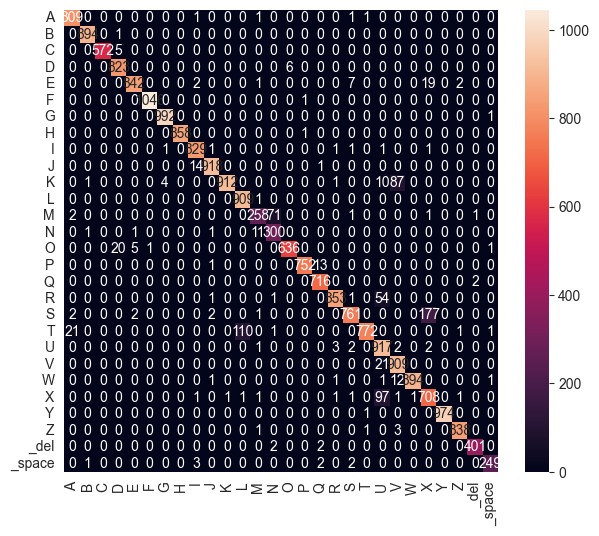

Classification Report
              precision    recall  f1-score   support

           A       0.97      1.00      0.98       813
           B       1.00      1.00      1.00       895
           C       1.00      0.99      1.00       577
           D       0.97      0.99      0.98       829
           E       0.99      0.96      0.98       873
           F       1.00      1.00      1.00      1047
           G       0.99      1.00      1.00       993
           H       1.00      1.00      1.00       859
           I       0.98      0.99      0.98       835
           J       0.99      0.98      0.99       933
           K       1.00      0.90      0.95      1015
           L       0.89      1.00      0.94       910
           M       0.93      0.77      0.85       334
           N       0.80      0.96      0.87       314
           O       0.99      0.96      0.97       663
           P       1.00      0.98      0.99       766
           Q       0.98      1.00      0.99       718
     

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

label_encoder.fit(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print_confusion_matrix(y_test_decoded, y_pred_decoded)

# Tensorflow-Lite

In [17]:
model.save(model_save_path, include_optimizer=False)

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmp8_v5smrr\assets


INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmp8_v5smrr\assets


13416

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.66272407e-09 6.92694871e-14 3.03373433e-08 7.12971104e-09
 9.71902767e-12 1.15868370e-09 1.00405764e-07 1.30564309e-04
 1.26969454e-07 5.06496406e-07 6.19185805e-21 7.38705694e-07
 3.72745092e-07 1.30790875e-06 1.98074647e-11 9.99382138e-01
 4.08770429e-04 5.18182719e-13 6.22791662e-12 1.35837528e-08
 1.89728028e-14 2.07709024e-12 3.51595706e-13 4.15097601e-15
 7.99192934e-11 1.23236316e-06 7.36548827e-05 3.44443976e-07]
15
